# Problema Eléctrico y Térmico

Nota: a este documento no lo podremos ejecutar de manera dinámica con Binder, sólo lo podrán correr si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

### Referencias

- Sacamos ideas del siguiente [enlace](https://github.com/sheldonkhall/MITA-model), desarrollado por Sheldon K Hall.

# Ablación por Radiofrecuencia usando MEF

Antes de comenzar con el código FEniCS, presentaremos una breve introducción teórica. La simulación de ARF en cualquier tejido implica dos problemas físicos acoplados modelados por la ecuación eléctrica y la ecuación de biocalentamiento (**ecuaciones en derivadas parciales**), que se presentan brevemente. El daño térmico se evalúa considerando la ecuación de Arrhenius (**ecuación diferencial ordinaria**), que también se comenta. Para una introducción a las aplicaciones ver el siguiente [video](https://youtu.be/93oMkYl7mRo). La estructura de esta sección es la siguiente: primero la teoría, luego la estrategia de la solución numérica y finalmente el código.

Todo está implementado en el *ejemplo25.py* de la carpeta ejemplos y la malla está subida como *rfa-tissue.geo*

## Teoría

### Ecuación eléctrica

En RFA el calor ($q_{RF}$) es generado por el efecto Joule, aplicando una corriente eléctrica a la región deseada. Este calor depende de la conductividad eléctrica ($ \sigma $) y del campo eléctrico ($ E $) y viene dado por la ecuación $q_{\text{RF}} = \sigma\left| E \right|^{2} $. El campo eléctrico se define como $ E = - \nabla V $, donde $ V $ es el voltaje. Este último se calcula resolviendo la llamada ecuación de Poisson en el volumen (dominio) deseado $ \Omega $:

$$\begin{equation} \nabla \cdot \left(\sigma \nabla V \right) = 0.\end{equation}\tag{1}$$

La conductividad eléctrica puede depender de la posición y la temperatura. Ec. (1) es una __*ecuación diferencial en derivadas parciales*__ (PDE) y se puede resolver si se conocen las __*condiciones de contorno*__, en nuestro caso (archivo .geo) hemos establecido:

- $V = 50$ V in the tagged with 2 (Physical Line(2) = {1,2,4}; // active electrode (metal)).
- $V = 0$ V in the tagged with 3 (Physical Line(3) = {11,12}; // passive electrode, V = 0).

Estas son las condiciones de contorno de Dirichlet. Los dominios de las condiciones de contorno se llamarán $ \Gamma $, en particular para una condición de contorno de Dirichlet $ \Gamma_{\text{D}} $.

### Ecuación de biocalentamiento

La temperatura $ T $ se obtiene resolviendo la PDE gobernante para el problema térmico, que es la ecuación del biocalentamiento. La relación de la entalpía (*h*) y la temperatura es la siguiente:

$$\begin{equation} \frac{\partial \rho h}{\partial t} = \nabla \cdot \left( k \nabla T\right) +q_{\text{RF}} +\beta \rho_{\text{b}}c_{\text{b}}\omega_{\text{b}}\left(T_{\text{b}}-T\right)+Q_{\text{met}}\end{equation}\tag{2}$$

donde $ k $ es la conductividad térmica, $ \rho $ es la densidad, $ c $ es el calor específico, $ \omega $ es la perfusión. $ Q_{\text {met}} = 0 $ (calor metabólico) se establece porque es insignificante en RFA. El parámetro $ \beta $ es un coeficiente que toma los valores de 0 y 1, según el valor del daño térmico (lo explicaremos más adelante). Los parámetros mencionados pueden ser funciones de posición y temperatura. El subíndice b indica que son parámetros sanguíneos.

En cuanto al término de entalpía, la dependencia con la temperatura es la siguiente:

$$\begin{equation}\frac{\partial \rho h}{\partial t} = \frac{\partial T}{\partial t} \cdot \begin{array}{l} \rho_{\text{l}} c_{\text{l}} \; \text{ if } \; T < 99 ^{\text{ o}}\text{C }\\h_{\text{fg}}C \; \text{  if } \; 99 \leq T \leq 100  ^{\text{ o}}\text{C }\\ \rho_{\text{g}}c_{\text{g}} \; \text{ if } \; T > 100  ^{\text{ o}}\text{C }\end{array} \end{equation} \tag{3}$$

Las condiciones de borde son:

- $T = 37 ^{\text{ o}}\text{C}$ in the tagged with 3 and 4 (Physical Line(3) = {11,12}; // passive electrode, U = 0 V and 37 deg and Physical Line(4) = {8,17,18}; // I = 0 A and 37 deg).
- $T = 40 ^{\text{ o}}\text{C}$ in the tagged with 5 (Physical Line(5) = {3}; // perfusion constant temperature 40 deg). This simulates an irrigated electrode perfused with saline solution at $40 ^{\text{ o}}\text{C}$

estas también son condiciones de Dirichlet. 

El efecto térmico de la sangre circulante en el tejido (asumiendo un flujo alto) se puede modelar mediante coeficientes de transferencia térmica entre la sangre y el electrodo ($ h_{\text{p}} = 3346 \; \text{W} / \text{m}^{2} \text{ K} $). Se conocen como condiciones de frontera de Robin y se expresan como: $-\frac{\partial T}{\partial n} = h_{\text{i}} \left(T - T_{\text{b}} \right) $, para $ \text{i} = \text{t}, \text{e} $ donde $ n $ es el vector unitario que apunta en la dirección normal del límite (línea en 2D o superficie en 3D). Establecemos esta condición en las líneas marcadas con 6 y 7, respectivamente (Línea física (6) = {16}; // pérdida de calor por convección (plástico) Línea física (7) = {7}; // pérdida de calor por convección (tejido)).

En el caso de las condiciones de contorno de Robin y Neumman, las llamaremos $ \Gamma_{\text{R}} $ y $ \Gamma_{\text{N}} $, respectivamente.

Como este problema es una ecuación de calor transitorio, también se necesita la condición inicial:

$$ T \left(x, y, t = 0 \; \text{s} \right) = 37^{\text{o}} \text{C}, $$

hacemos implícita aquí la dependencia de la posición y el tiempo.


### El daño térmico

El modelo de daño de Arrhenius asocia la temperatura con el tiempo de exposición mediante una relación cinética de primer orden:

$$\begin{equation} D\left(t\right) = \int_{0}^{t} Ae^{-\frac{\Delta E}{RT}} d\tau \end{equation} \tag{4},$$

donde $ A $ y $ \Delta E $ son un factor de frecuencia y la energía de activación para la reacción de daño irreversible, respectivamente. $ R $ es la constante universal del gas. Evaluamos el daño térmico por la isolina D99, que es $ D = 4.6 $ (99% de probabilidad de muerte celular). Esto significa que cuando el valor de $ D = 4.6 $ cambiamos el valor de $ \beta $ a cero, entonces el término de perfusión sanguínea de la ecuación de biocalentamiento es nulo. La ubicación de la isolina D99 define el tamaño de la zona de coagulación. Para el propósito de este tutorial expresamos Ec. (4) como una ecuación diferencial ordinaria (EDO): 

$$\frac{dD}{dt}=Ae^{-\frac{\Delta E}{RT\left(t\right)}}\tag{5}.$$


Tenga en cuenta que hacemos explícita la dependencia de la temperatura en el tiempo ($ T \left(t \right) $) para mostrar que da como resultado una EDO no lineal que debe resolverse numéricamente en cada paso de tiempo.


### La formulación variacional

El punto de partida de los métodos de EF es expresar el PDE en *forma variacional* para resolver el problema débil. Por ejemplo, si trabajamos con Ec. (1) (ligeramente modificado para generalizar el razonamiento, es decir, $ - \nabla \cdot \left(\sigma \nabla V \right) = f $, donde $ f $ es una fuente conocida), primero tenemos que multiplicar el PDE mediante una función $ v $ (__*función de prueba*__) e integrar la ecuación resultante en el dominio $ \Omega $.

$$-\nabla \cdot \left(\sigma \nabla V \right) = f \Rightarrow -\int_{\Omega}\nabla \cdot \left(\sigma \nabla V \right)\; v\; \text{dx} = \int_{\Omega} f \; v \; \text{dx}.$$


Denotamos aquí $ \text{dx} $ como el diferencial del dominio $ \Omega $ en este ejemplo: $ \text{dx} = dxdy $. Tenga en cuenta que la parte izquierda de la ecuación (1) tiene derivadas de segundo orden. La resolución de PDE por FEM requiere la integración por partes para obtener solo derivadas de primer orden. Esto se obtiene aplicando la fórmula de Green.

$$-\int_{\Omega}\nabla \cdot \left(\sigma \nabla V \right)\; v\; \text{dx} = \int_{\Omega} \sigma\nabla V \cdot \nabla v \;\text{dx} - \int_{\Gamma} \sigma \; n\cdot \nabla V \;v \;\text{ds}.\tag{5}$$

El término $ n \cdot \nabla V $ es la derivada de $ V $ en la dirección normal hacia afuera $ n $ en el límite respectivo y se denota como $ \frac{\partial V}{\partial n} $. El diferencial $ \text{ds} $ se define en el dominio de límite $ \Gamma $. Reordenando Ec. (5):

$$\int_{\Omega} \sigma \nabla  V \cdot \nabla v \;\text{dx} = \int_{\Omega} f \; v \; \text{dx}-\int_{\Gamma} \sigma \; \frac{\partial V}{\partial n} \;v \;\text{ds}.\tag{6}$$

En nuestro problema eléctrico, como solo hay condiciones de contorno de Dirichlet y se puede hacer que $ v $ desaparezca en los límites, el segundo término a la derecha de la Ec. (6) también desaparece:

$$\int_{\Omega} \sigma \nabla  V \cdot \nabla v \;\text{dx} = \int_{\Omega} f \; v \; \text{dx}.\tag{7}$$

La parte izquierda de esta ecuación se llama __*forma bilineal*__ y la derecha __*forma lineal*__ y generalmente se denotan por: $ a \left(V, v \right) $ y $ L \left ( v \right) $, respectivamente. Tenga en cuenta que $ a $ es una función de $ V $ y $ v $, y $ L $ es solo una función de $ v $ (porque $ f $ es la fuente conocida).
En el caso de la ecuación del biocalentamiento, el procedimiento es similar, con la adición de las condiciones de contorno de Robin (convectivas). Se modelan como $ -k \frac{\partial T}{\partial n} = h \left(T - T_{\text{b}} \right) $. Esta condición luego se escribe como:

$$-\int_{\Gamma_{\text{R}}} k \; \frac{\partial T}{\partial n} \;v \;\text{ds} = \int_{\Gamma_{\text{R}}} \; h\left( T - T_{\text{b}}\right)  \;v \;\text{ds}\tag{8}$$

Ecs. (6-8) están escritos en FEniCS de una manera muy similar, por ejemplo, Ec. (7) se codifica como:

In [ ]:
a = sigma*inner(nabla_grad(V), nabla_grad(v))*dx
L = f*v*dx

y se resuelve, como siempre, con:

In [ ]:
solve(a == L, V, bcs)



## Estrategia numérica

Cabe subrayar que tenemos que resolver tres ecuaciones acopladas: dos PDE y una ODE. Necesitamos discretizarlos en el espacio y el tiempo. En este apartado comentamos la discretización del tiempo.

### Enfoque general

Tenga en cuenta que la ecuación. (1) es un enfoque eléctrico cuasiestático, que se utiliza porque la corriente resistiva es mucho más baja que la corriente de desplazamiento en RF. La ecuación (1) solo está relacionada con la ecuación. (2) por la dependencia de la conductividad eléctrica de $ T $ ($ \sigma \left(T \right) $). Por lo tanto, un enfoque es resolver la ecuación. (1) con una temperatura conocida considerando una conductividad eléctrica constante a esta temperatura particular, es decir, constante por partes dentro del intervalo de tiempo, comenzando desde la temperatura corporal ($ 37 ^ {\text{o}} \text{C} $). De esta forma se desacopla el voltaje de la temperatura, considerado como un acoplamiento débil. El enfoque general puede describirse mediante los siguientes __*pasos*__:

1. Inicialice la temperatura de la geometría.
2. Con temperaturas conocidas, resuelva la ecuación. (1) para obtener $ q_{\text{RF}} $.
3. Con $ q_{\text{RF}} $ conocidos resuelva la ecuación. (2).
4. Con temperatura conocida integre la ecuación. (4).
5. Vaya al paso 2 y repita.

### Esquema de discretización del tiempo

La ecuación (2) depende del tiempo y se puede resolver con un simple enfoque de Euler hacia atrás. La primera derivada se aborda mediante:

$$\begin{equation}\left(\frac{\partial T}{\partial t}\right)^{\left(n+1\right)}\approx \frac{T^{\left(n+1\right)}-T^{\left(n\right)}}{\Delta t} \end{equation},\tag{9}$$

donde el superíndice $ \left(n \right) $ indica el paso de tiempo $ n $. El primer paso es conocido, porque tenemos la condición inicial $ T \left(x, y, t = 0 \; \text{s} \right) = 37 ^ {\text{o}} \text{C} $.

### Dependencia de los parámetros con la temperatura

En el ejemplo de este tutorial, consideramos tres parámetros que dependen de la temperatura: conductividades eléctricas y térmicas y el término de entalpía (ver Ec. (3)). Modelamos la conductividad con una dependencia lineal de la temperatura. Por ejemplo, la conductividad eléctrica es: $ \sigma\left(T \right) = \sigma \left(T_{0} \right) \cdot \left(1+ \frac{\Delta \sigma}{\sigma \left(T_{0} \right)} \cdot \left(T-T_{0} \right) \right) $.

## Código

Comentaremos solo algunos pasos que son diferentes a lo que hemos venido haciendo durante los tutoriales anteriores.

### Función *electric_problem*

Aquí definimos la función que resuelve el problema eléctrico utilizando FEniCS. Tiene las siguientes entradas: problemname, mesh, interior, boundaries, emp, Theta, and thp.

- problemname: es el nombre del archivo .geo, en este ejemplo: 'rfa-atrial-wall'
- mesh: es la malla cargada a FEniCS por medio de 'mesh = Mesh(problemname+".xml")', como ya lo hemos resuelto en explicaciones anteriores (ver el siguiente [enlace](https://github.com/rirastorza/Intro2FEM/blob/master/Apendices/ejemplo_convierte_mallas2D.ipynb)).
- interior: son los subdominios que se cargan como 'interior = MeshFunction("size_t", mesh, problemname+"_physical_region.xml")'
- boundaries: son las condiciones de contorno que se cargan con la siguiente sentencia 'boundaries = MeshFunction("size_t", mesh, problemname+"_facet_region.xml")'
- emp: es la clase con que se cargan los parámetros eléctricos de los tejidos.
- Theta: es el incremento de temperatura $\Delta T = T-T_{0}$ de paso previo.
- thp: es la clase con que se cargan los parámetros térmicos.

Las salidas son:

- qRF: calor generado por efecto Joule.
- resistance: impedancia del modelo.
- power: potencia aplicada al modelo.
- U: tensión en toda la geometría.

#### Estructura de la función

Describimos la estructura general de la función, para ver detalles seguir el siguiente enlace [Section 3) Runing a simulation](https://github.com/rirastorza/RFA-tutorial/blob/master/run/coding.ipynb).

Las condiciones de bordes se pasan de la siguiente manera:

In [ ]:
bcs = []
bcs.append(DirichletBC(W, emp.Vprobe, boundaries, 2))#Active electrode
bcs.append(DirichletBC(W, emp.Vprobe, boundaries, 5))#Active electrode at 40 Deg
bcs.append(DirichletBC(W, emp.V0, boundaries, 3))#Passive electrode

Como lo hemos visto anteriormente, se juntan todas las condiciones de Dirichlet en una lista de python las de Robin se pasan en la formulación variacional.

Como el modelo contiene diferentes tejidos que tienen diferentes conductividades se debe crear una clase donde se pasan los diferentes dominios:

In [ ]:
class MATERIAL(UserExpression):
        def __init__(self, subdomains,s_1,s_2,s_3, s_4,**kwargs):
            super().__init__(**kwargs)
            self.subdomains = subdomains
            self.s_1 = s_1
            self.s_2 = s_2        
            self.s_3 = s_3
            self.s_4 = s_4        
        def eval_cell(self, values, x, cell):
            if self.subdomains[cell.index] == 1:
                values[0] = self.s_1#Atrial wall
            elif self.subdomains[cell.index] == 2:
                values[0] = self.s_2#Connective tissue
            elif self.subdomains[cell.index] == 3:
                values[0] = self.s_3#Plastic
            else:
                values[0] = self.s_4#Blood

Esta clase se deriva de la clase *UserExpression*, específicamente las entradas son: los *subdominios* (con los tags de cada región) y los parámetros de cada subdominio *s_1*, *s_2*, *s_3*, y *s_4* (a 37 $^ {\text{o}} \text{C}$). Llamamos esa clase como:

In [ ]:
#Diferent baseline conductivities
conductivities = [0.28, 0.2, 1e-5 , 0.667]   
s_1 = conductivities[0] #Atrial wall
s_2 = conductivities[1] #Connective tissue
s_3 = conductivities[2] #Plastic
s_4 = conductivities[3] #Blood
    
SIGMA = MATERIAL(interior,s_1,s_2,s_3, s_4,degree=0)

El grado = 0 indica que es una función escalar.

Remarcamos que las conductividades eléctricas dependen de la temperatura son la pared auricular y el tejido conectivo, el resto para simplificar se dejó constante. Esto se implementa de la siguiente forma, se multiplica *SIGMA* con la función $\left(1+\frac{\Delta \sigma}{\sigma_{0}}\left(T-T_{0}\right)\right)$:

In [ ]:
sigma = (1.0 + cond_rate*(T_p))*SIGMA

Para verificar que hemos seteado bien los valores para cada dominio podemos graficarla:

In [ ]:
File("outputs/sigma.pvd") << project_axisym(SIGMA,W)

![figure1.png](attachment:figure1.png "Conductivity map")
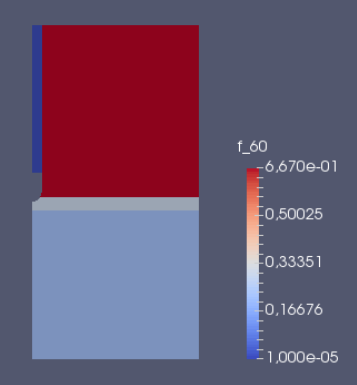

Luego definimos la función ensayo y prueba como ya sabemos:

In [ ]:
V = TrialFunction(W)
v = TestFunction(W)

Y finalmente, establecemos la formulación variacional del problema eléctrico:

In [ ]:
a = sigma*inner(nabla_grad(V), nabla_grad(v))*r*dx
L = source*v*r*dx

Luego resolvemos el problema:

In [ ]:
V = Function(W)
solve(a == L, V, bcs)
File("outputs/voltage.pvd") << V

El dibujo utilizano paraview nos da:

![figure2.png](attachment:figure2.png "Voltage")
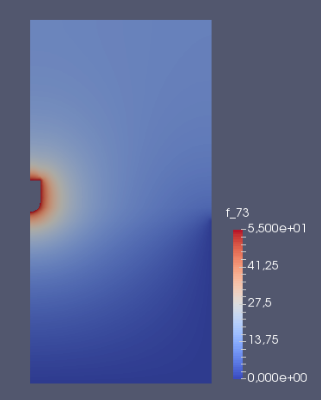

Como estamos interesados en computar el calor generado por la RF, entonces necesitamos el calor generado $q_{\text{RF}}$. Lo hacemos resolviendo el siguiente problema, también con FEM, $q_{\text{RF}}=\sigma \nabla V \cdot \nabla V$.

In [ ]:
v = TestFunction(W)
qRF = TrialFunction(W)
a = qRF*v*r*dx
L = v*sigma*inner(nabla_grad(V), nabla_grad(V))*r*dx
qRF = Function(W)
solve(a == L, qRF)

El valor del calor $q_{\text{RF}}$ de cada paso temporal será utilizado como entrada en la función *rfa_bioheat_problem*.

### Función *rfa_bioheat_problem*

La función *rfa_bioheat_problem* tiene las siguientes entradas: mesh, interior, boundaries, problemname, dt,tmax, thp, y emp. Algunas de estas ya fueron descriptas en la función *electric_problem*. Los diferentes son:

- dt: paso de tiempo.
- tmax: tiempo total de la simulación.

Las salidas son: projectaxisym(Theta,W), project_axisym(Vfield,W),projectaxisym(Theta+310.15-273.15,W), store_resistance,store_sensortemp,store_power,tiempo,CDeath

- Theta: el valor final de $T-T{0}$ de la geometría.
- Vfield: el valor final de la tensión.
- Theta_+310.15-273.15: el valor final en Celsius.
- store_resistance: un arreglo con el valor de la impedancia en cada paso de tiempo.
- store_sensortemp: un arreglo que mide la temperatura en el sensor en cada paso de tiempo.
- store_power: un arreglo con la potencia en cada paso de tiempo.
- time: un arreglo que posee el tiempo.
- CDeath: el valor integrado de la función de daño de Arrhenius en la geometría.

#### Estructura de la función

Describimos algunso puntos, el código completo está en el siguiente [enlace](https://github.com/rirastorza/RFA-tutorial/blob/master/run/coding.ipynb).

Las variables relacionadas con el timpo deben ser definidas como expresiones porque deben ser actualizadas en cada paso de tiempo.

In [ ]:
dte = Expression('dt', degree=1, dt=0.)
cur_time = Expression('t', degree=1,t=0.)

La tempratura es parametrizada como $\Delta T = T -T_{0}$ donde $T_{0}=37 ^{\text{ o}}\text{C}$ está en Kelvin. Inicializamos la temperatura, impedancia y luego llamamos a la función *electric_problem* para inicializar la fuente de calor y la guardamos en *qext*.

In [ ]:
# initial uniform temperature
Theta_prev = project_axisym(thp.T_initial-Constant(310.15),W)
# initial values (if needed)
resistance = 0.
Q, resistance, power, Vfield = electric_problem(problemname, mesh, interior, boundaries, emp, Theta_prev, thp) 
qext = project_axisym(Q,W)


La diferencia principal con la función *electric_problem* es que la bioheat depende del tiempo, entonces necesitamos aplicar Euler hacia atrás. La Ec. (2) es reparametrizada con $\Theta = T-T_{0}$:

 $$\rho c \frac{\Theta^{\left(n+1\right)}-\Theta^{\left(n\right)}}{\Delta t} =\nabla \cdot \left( k \nabla \Theta^{\left(n+1\right)}\right) +q_{\text{RF}} -\beta \rho_{\text{b}}c_{\text{b}}\omega_{\text{b}}\Theta^{\left(n+1\right)}$$
 
Y la forma variacional es codificada en FEniCS como:

In [ ]:
# Heat transfer variational form
a = KAPPA*dependenceTkappa*inner(nabla_grad(Theta_), nabla_grad(v))*r*dx+ v*omega*thp.rho*thp.c*Theta_*r*dx+ v*RHOxCALESP/dte*Theta_*r*dx+ht*Theta_*v*r*dss(7)+hp*Theta_*v*r*dss(6)##
L = f*v*r*dx + v*RHOxCALESP/dte*Theta_prev*r*dx

Note que las variables $\Theta^{\left(n+1\right)}$ y $\Theta^{\left(n\right)}$ son las variables *Theta_* y *Theta_prev*. Note también que las condiciones convectivas son codificadas como: *v$*$RHOxCALESP/dte$*$Theta_$*$r$*$dx+ht$*$Theta_$*$v$*$r$*$dss(7)+hp$*$Theta_$*$v$*$r$*$dss(6)*. Las sentencias *dss(6)* y *dss(7)* denotan los tags plástico-sangre y electrodo-sangre (ver completo en el [enlace](https://github.com/rirastorza/RFA-tutorial/blob/master/mesh%20generation/meshgenration.ipynb)).

Los parámetros: densidad por calor específico $\rho C$ y conductividad térmica $k$ se codifican reutilizando la clase *MATERIAL* de manera similar a la conductividad eléctrica.

Finalmente la iteración se hace de la siguiente manera:

In [ ]:
while t <= tmax+eps:
    qRF, resistance, power, Vfield = electric_problem(problemname, mesh, interior, boundaries, emp, Theta_prev, thp)
    # assemble each iteration to account for previous time step
    dte.dt = dt
    cur_time.t = t
    f.assign(qRF)
    b = assemble(L, tensor=b)
    A = assemble(a, tensor=A)

    for bc in bcs:
        bc.apply(A, b)
    
    solve(A, Theta_.vector(), b)#

### Función de la entalpía (uso de condicionales)

El uso de funciones simbólicas de FEniCS lo maneja UFL (sin que nos demos cuenta). Aquí vamos a utilizar algunas de las funciones para poder codificar la Ec. (3) que contiene una función a trozos que debe ser evaluada en cada paso de la simulación. Para ello observemos la parte del código:

In [ ]:
rc1 = conditional(lt(T_prev,99.0), rho*C, 0.)

#rc1 = conditional(lt(Theta_prev,thp.Tl), thp.rho_c_t, 0.) 
rc2 = conditional(uflcond.operators.And(ge(Theta_prev,thp.Tl),le(Theta_prev,thp.Tu)), (thp.rho_c_t+thp.rho_c_v)/2+thp.rho*thp.Lh*thp.Cliq*(1./(thp.Tu-thp.Tl)), 0.)
rc3 = conditional(gt(Theta_prev,100), thp.rho_c_v, 0.)
    
# Heat transfer variational form
a = KAPPA*dependenceTkappa*inner(nabla_grad(Theta_), nabla_grad(v))*r*dx+ v*omega*thp.rho*thp.c*Theta_*r*dx+thp.hp*Theta_*v*r*dss(30) + v*rc1/dte*Theta_*r*dx + v*rc2/dte*Theta_*r*dx + v*rc3/dte*Theta_*r*dx
L = f*v*r*dx + v*rc1/dte*Theta_prev*r*dx + v*rc2/dte*Theta_prev*r*dx + v*rc3/dte*Theta_prev*r*dx